In [2]:
# "Проверка гипотезы: На выходных (суббота и воскоресенье) обычно падает курс"

In [79]:
from get_data import get_polo_data
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn import metrics 
from sklearn import svm
from pandas import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
# Беру статистику за 2000 дней 
sd = get_polo_data(pair="USDT_BTC", frame=(2000+1)*60*60*24,zoom='1D')

DEBUG:poloniex:Getting 2019-11-20 11:40:00 - 2019-11-21 13:18:11 USDT_BTC candles from Poloniex...
DEBUG:poloniex:Updating USDT_BTC database with 308 entrys...
100%|██████████████████████████████████████| 308/308 [00:00<00:00, 1069.44it/s]
DEBUG:poloniex:Getting USDT_BTC chart data from db


In [5]:
# Скачалось чуть меньше 2000 дней, ну да ладно
print(len(sd))
print(len(sd)-len(sd.dropna()))

1737
0


In [6]:
# Заполняю столбец. Если курс вырос, то 1. Если нет, то '-1' 
sd["delta"]=sd["close"]-sd["open"]
sd["isgrowing"]=sd['delta'].map(lambda delta: math.copysign(1, delta ))

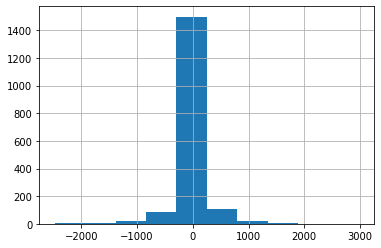

In [7]:
# Это просто построил график. Посмотреть на распределение   
(sd['close']-sd['open']).hist(bins=10)

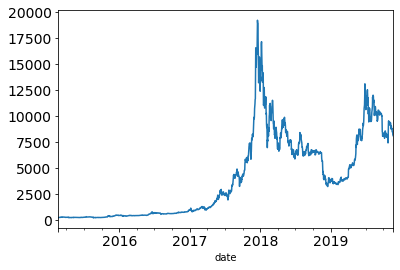

In [8]:
# Это тоже график. Напосмотреть себе
sd['open'].plot(fontsize=14)

In [41]:
# Заполняю столбец День недели 
sd['WeekDay'] = sd.index
sd['WeekDay'] = sd['WeekDay'].dt.weekday_name
sd['WeekDayNmb'] = sd.index
sd['WeekDayNmb'] = sd['WeekDayNmb'].dt.weekday

In [42]:
sd

,open,high,low,close,volume,weightedAverage,delta,isgrowing,WeekDay,WeekDayNmb
date,,,,,,,,,,
2015-02-19,225.000000,244.000000,225.000000,244.000000,4.627631e+01,239.036070,19.000000,1.0,Thursday,3
2015-02-20,244.000000,245.000000,240.250000,240.250000,5.589490e+01,241.513338,-3.750000,-1.0,Friday,4
2015-02-21,240.250000,245.000000,240.250000,245.000000,1.472224e+01,241.404514,4.750000,1.0,Saturday,5
2015-02-22,245.000000,249.000000,235.000000,235.000000,1.291212e+02,243.707271,-10.000000,-1.0,Sunday,6
2015-02-23,235.000000,235.001000,235.000000,235.000000,9.656756e+01,235.000082,0.000000,1.0,Monday,0
...,...,...,...,...,...,...,...,...,...,...
2019-11-17,8490.802181,8625.808765,8373.000000,8502.200000,6.460234e+06,8516.183132,11.397819,1.0,Sunday,6
2019-11-18,8496.380562,8500.380562,8055.985107,8190.297868,1.078957e+07,8391.032914,-306.082695,-1.0,Monday,0
2019-11-19,8188.309689,8220.572985,8000.000000,8129.410000,1.033630e+07,8128.944991,-58.899689,-1.0,Tuesday,1


In [10]:
# Теперь создаю новый Dataframe. По правилам.А ты как делаешь? 
target_features=['isgrowing']
nominal_features=['WeekDay']

In [11]:
data_nom=sd[nominal_features]
data_nom_dum=pd.get_dummies(data_nom)
data_target=sd[target_features]
data_my=pd.concat([data_nom_dum,data_target],axis=1)

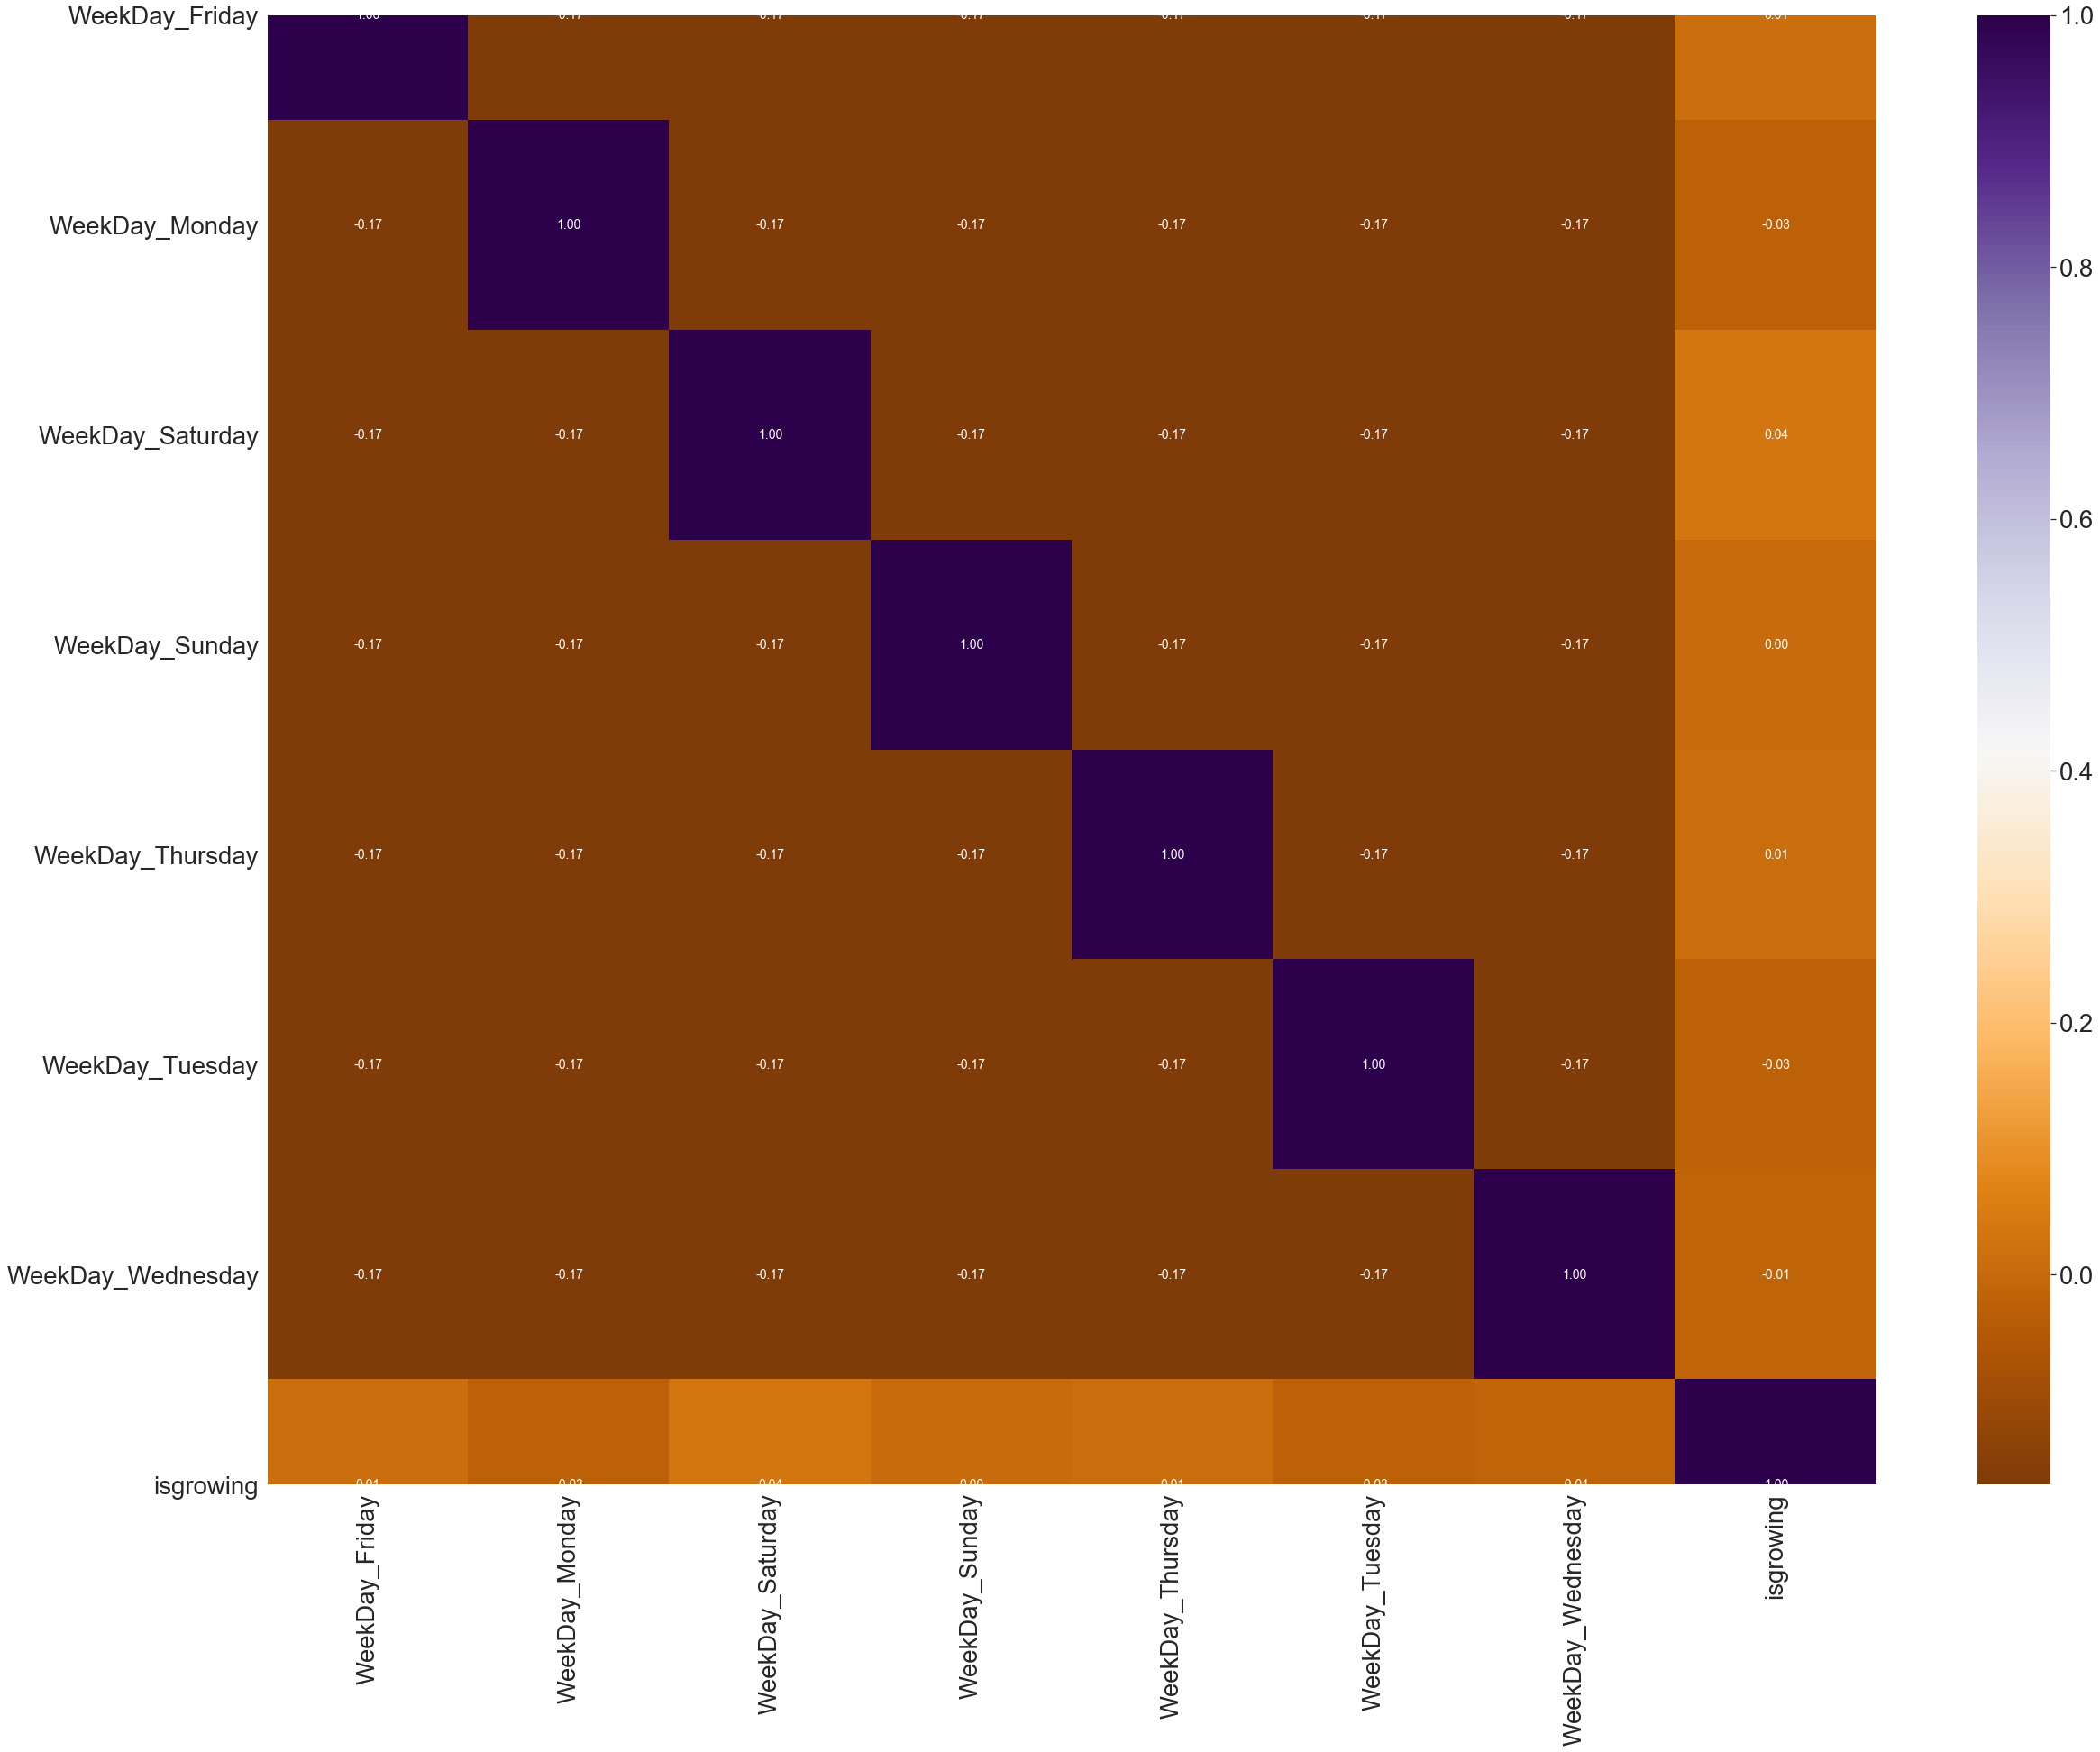

In [12]:
# Строю ковариационную матрицу
sns.set(font_scale=2.5)
plt.figure(figsize=(40,30))
corr_matrix=data_my.corr()
sns.heatmap(corr_matrix,annot=True,fmt = ".2f",cbar = True,cmap='PuOr',annot_kws={"size":14})

In [13]:
# Судя по результатам, никакой связи нет. Везде значения меньше 0.1 
# Но может быть в воскресенье, и то цена не падает, а растет. Вроде так??? 
for i in corr_matrix:
    print(i, corr_matrix[i]['isgrowing'])

WeekDay_Friday 0.011142510763952587
WeekDay_Monday -0.025281775492136126
WeekDay_Saturday 0.037632900768380995
WeekDay_Sunday 0.004519913262845418
WeekDay_Thursday 0.009289223337517537
WeekDay_Tuesday -0.02528177549213643
WeekDay_Wednesday -0.012036580489922196
isgrowing 1.0


In [14]:
# Ок. А может изменить гипотезу. Зависит ли разница между открытием и закрытием от дня недели.
# Добавляем в frame  еще один столбец delta 
data_my['delta']=sd['delta']

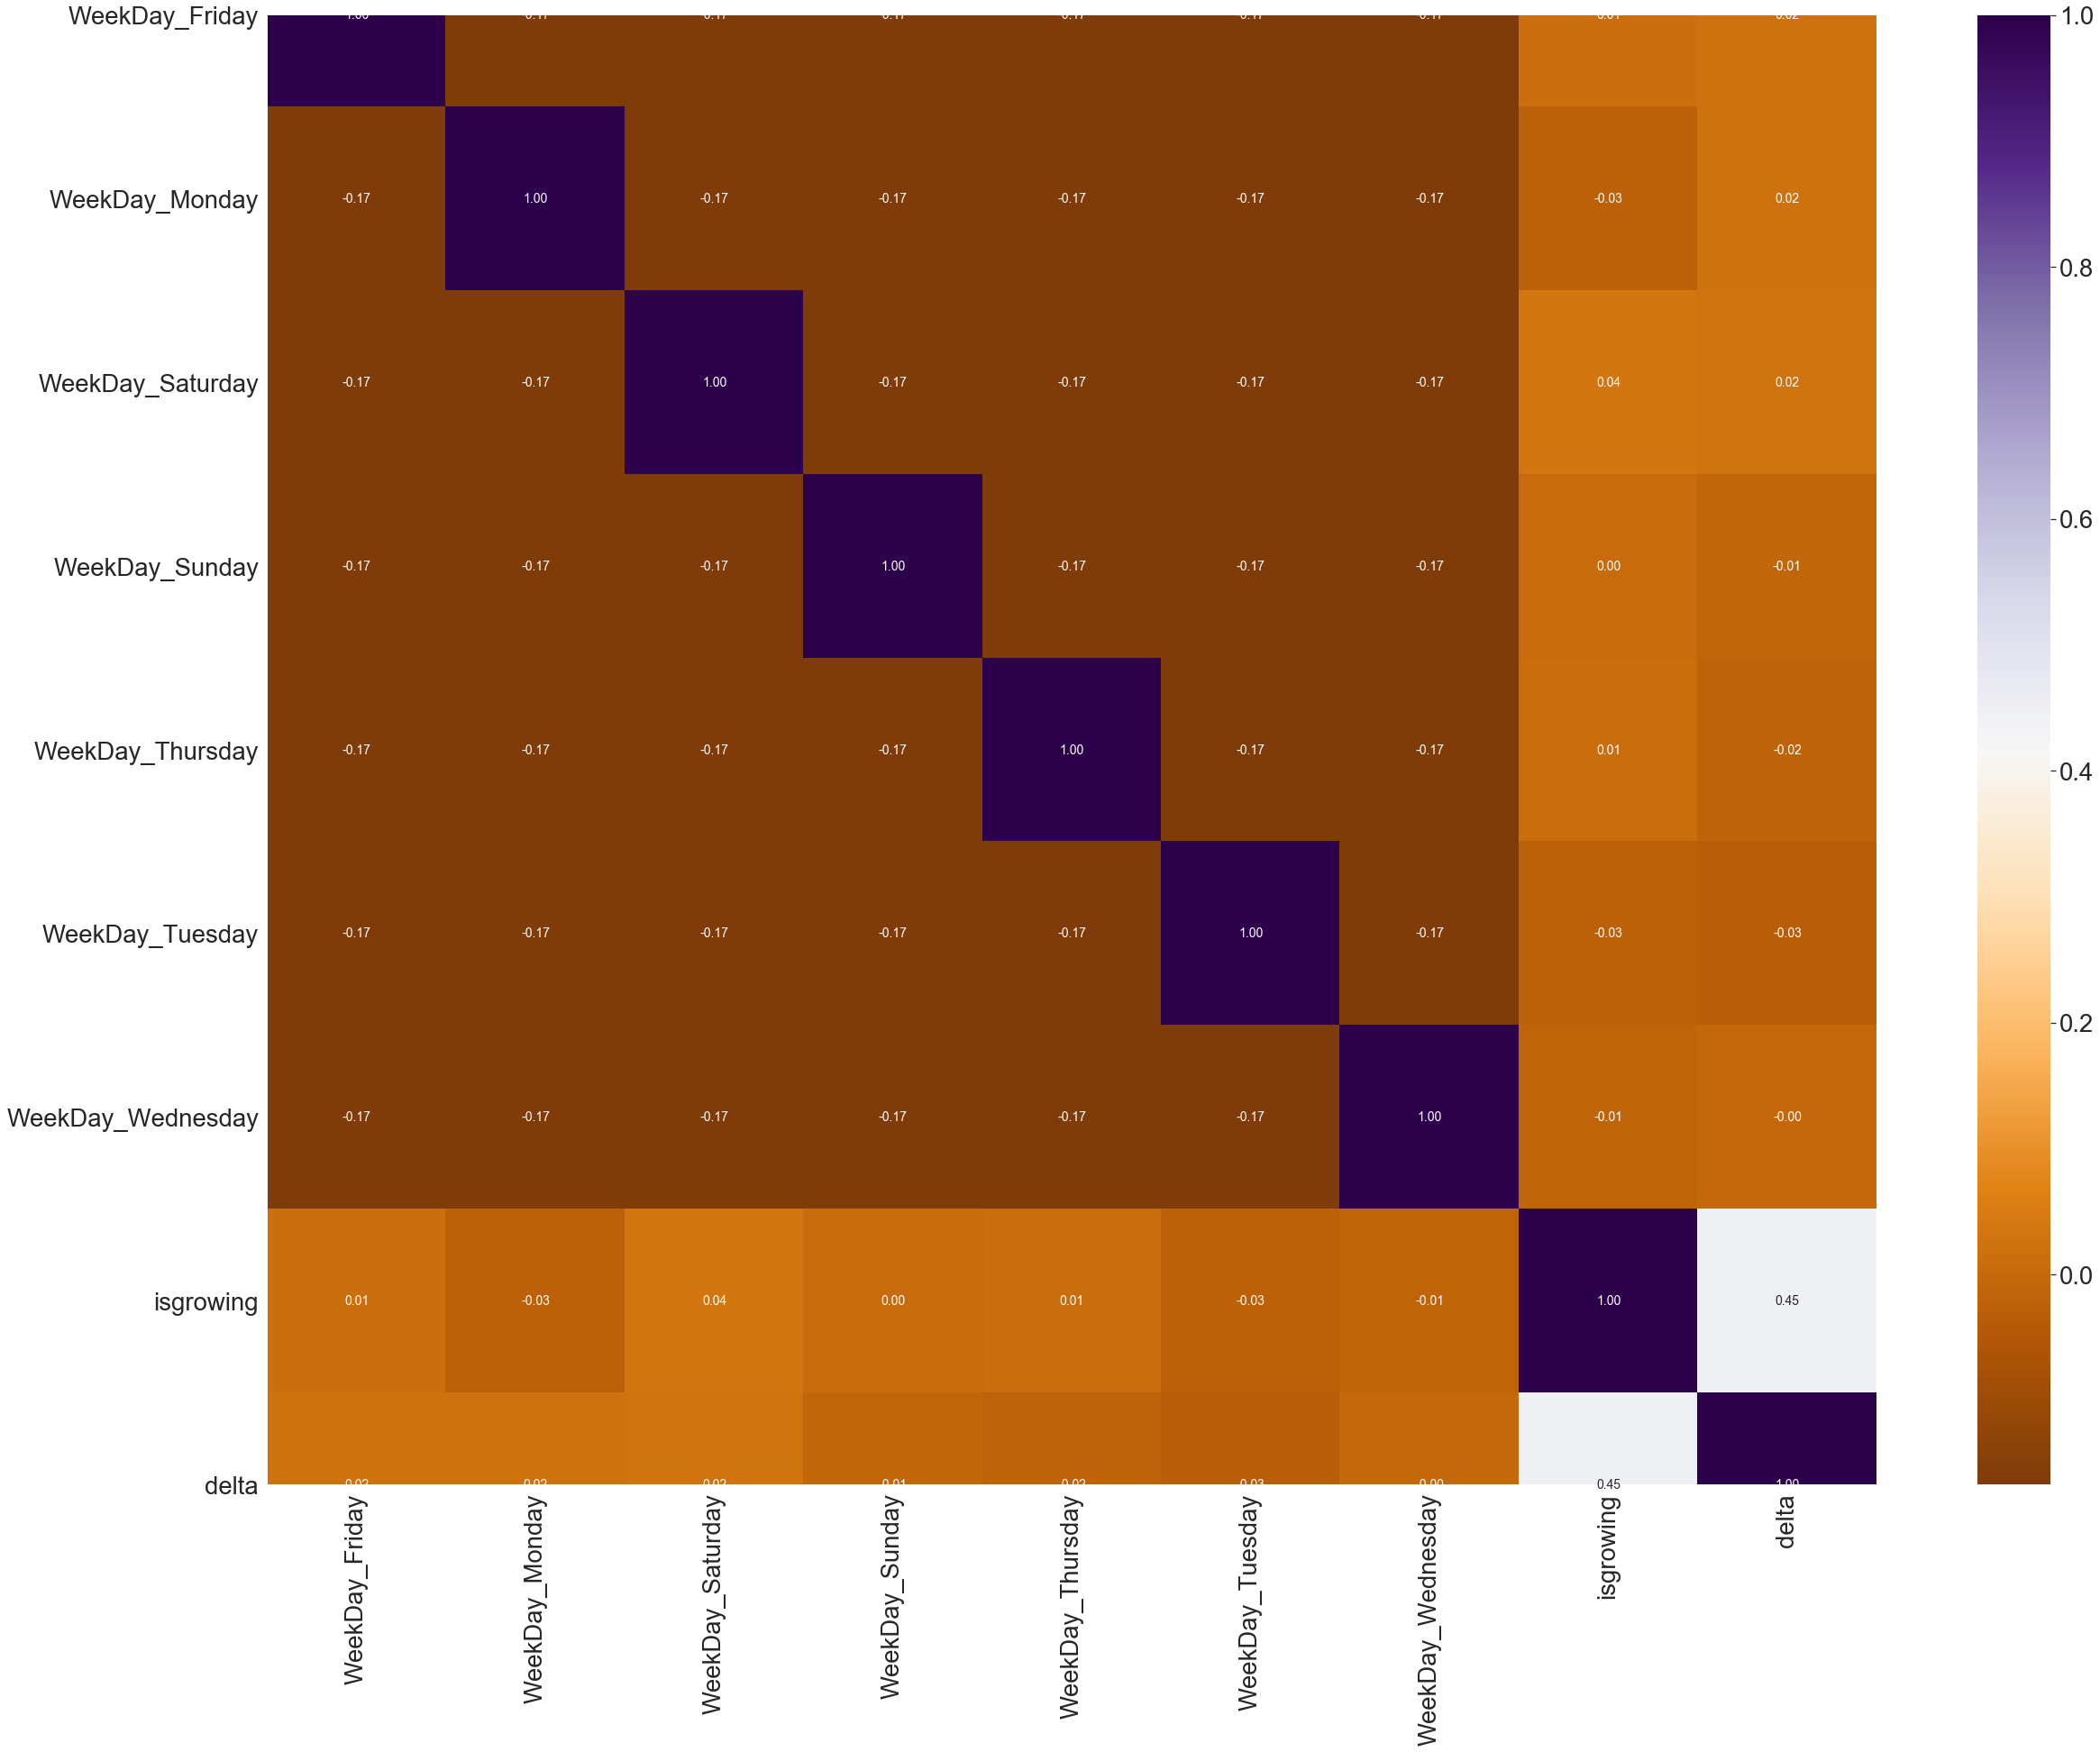

In [15]:
sns.set(font_scale=2.5)
plt.figure(figsize=(40,30))
corr_matrix=data_my.corr()
sns.heatmap(corr_matrix,annot=True,fmt = ".2f",cbar = True,cmap='PuOr',annot_kws={"size":14})

In [16]:
# Похоже что не фига не зависит. Как-то так?  
for i in corr_matrix:
    print(i, corr_matrix[i]['delta'])

WeekDay_Friday 0.02227999791884565
WeekDay_Monday 0.020011799195960817
WeekDay_Saturday 0.024597628203654347
WeekDay_Sunday -0.010100115566496847
WeekDay_Thursday -0.020473978645439688
WeekDay_Tuesday -0.03194221973210974
WeekDay_Wednesday -0.004338764799950765
isgrowing 0.44740110024886626
delta 1.0


In [ ]:
histohrams = sd.hist(grid=False, figsize=(10, 10), textsize=1)

In [98]:
# СЮДА ДОБАВИЛ СТОЛБЕЦ VOLUME. ИНАЧЕ БЫЛА ОШИБКА ЧТО "ОДНОМЕРРНЫЙ МАССИВ ВО ВХОДНЫХ ДАННЫХ - НЕ КОМИЛЬФО" 
train=sd[['WeekDayNmb','volume']]
target=sd['isgrowing']
train_parm, test_parm, train_indic, test_indic = model_selection.train_test_split(
    train, target, test_size = 0.3, random_state = 0)

In [104]:
model_rfc = RandomForestClassifier(n_estimators = 70) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01) 
model_svc = svm.SVC()

In [106]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

kfold=5
itog_val = {}
scores = cross_val_score(model_rfc, train, target, cv = kfold)
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_val_score(model_knc, train, target, cv = kfold)
itog_val['KNeighborsClassifier'] = scores.mean()
scores = cross_val_score(model_lr, train, target, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()
scores = cross_val_score(model_svc, train, target, cv = kfold)
itog_val['SVC'] = scores.mean()

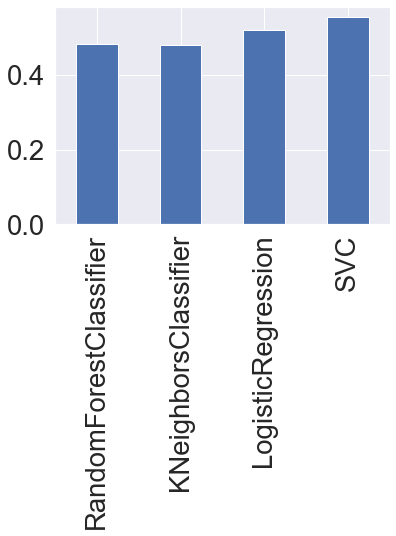

In [107]:
DataFrame.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

In [95]:
model_rfc.fit(train_parm, train_indic)
model_lr.fit(train_parm, train_indic) 
model_svc.fit(train_parm, train_indic)
model_knc.fit(train_parm, train_indic)
y_predicted = model_rfc.predict(test_parm)
print(metrics.classification_report(test_indic, y_predicted))
y_predicted = model_lr.predict(test_parm)
print(metrics.classification_report(test_indic, y_predicted))
y_predicted = model_svc.predict(test_parm)
print(metrics.classification_report(test_indic, y_predicted))
y_predicted = model_knc.predict(test_parm)
print(metrics.classification_report(test_indic, y_predicted))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



              precision    recall  f1-score   support

        -1.0       0.53      0.44      0.48       252
         1.0       0.55      0.63      0.59       270

    accuracy                           0.54       522
   macro avg       0.54      0.53      0.53       522
weighted avg       0.54      0.54      0.53       522

              precision    recall  f1-score   support

        -1.0       0.83      0.04      0.08       252
         1.0       0.53      0.99      0.69       270

    accuracy                           0.53       522
   macro avg       0.68      0.52      0.38       522
weighted avg       0.67      0.53      0.39       522

              precision    recall  f1-score   support

        -1.0       0.14      0.00      0.01       252
         1.0       0.51      0.98      0.67       270

    accuracy                           0.51       522
   macro avg       0.33      0.49      0.34       522
weighted avg       0.33      0.51      0.35       522

              preci